# General instructions for all labs

1. To turn in:
 - this python notebook, filled out (2 pts)
 - a *standalone* PDF report that contains all the plots, and the answers to all the discussion questions (2 pts)

2. Use of ChatGPT / CoPilot / etc:
   - Allowed, but you own everything that is generated
   - This means that any part of the solution can be asked in the quiz. It can be as detailed as "What was the batch size you used in training" or specific as "what exactly does masking do in this case?" Any discussion question is also game for a quiz question.
   - If I find AI usage to be excessive. I can individually drag any of you in for a 1-1 meeting, in which I grill you on your code. If it looks like irresponsible copy/pasting, without proper understanding, I reserve the right to drastically lower your grade, or even submit cases to GGAC for ethical review.
  
3. Use of peer collaboration:
   - In general not allowed. (Discussion / comparing answers is ok, but work on actual coding independently.)
   - Exceptions can be made if you all wrote your own training script, but 1. it takes forever to train or 2. you don't have great compute resources. Then you can share a trained model amongst yourself *and declare it on your pdf*. However, the code for training *still must be written by yourself*
     


## **Lab 1 Overview**

This lab explores how domain-specific training shapes NanoGPT’s internal representations and output behavior. You will train three separate *small* NanoGPT models on distinct, **tiny** corpora (each \~50–200 KB of text):

1. **Shakespeare corpus** – Short subset of public-domain plays.
2. **Wikipedia corpus** – Small scraped/cleaned sample from open Wikipedia dumps.
3. **Math textbook corpus** – Small public-domain math primer or textbook excerpt.

By comparing these models across zero-shot and few-shot settings, you will observe how the same generative architecture adapts its “classification” over the vocabulary depending on the training distribution.


## **Learning Outcomes**

By the end of the lab, students should:

1. Recognize that **generation is token-level classification**, and that domain-specific data shifts the learned classification boundaries.
2. Understand **zero-shot vs. few-shot** generalization in the context of specialized generative models.
3. Interpret **softmax confidence** and detect overconfidence/oversaturation phenomena.
4. Apply **model interpretability tools** (Grad-CAM) to compare how domain training changes token importance.
5. Connect all observations to **overfitting, evaluation metrics, and embeddings**.


## **Part 1 – Training Domain-Specific Models**

* Use the **same small NanoGPT config** (e.g., `n_layer=2`, `n_head=2`, `n_embd=128`, `block_size=64`) for all runs.
* Train on CPU or free Colab GPU — each model should converge in minutes given the small corpora and reduced parameters.
* Monitor:

  * Training loss curves.
  * Qualitative performance of generated samples.

This section mostly requires you to run scripts that are already written. At each step, pay close attention to the comments, as you may be asked about them in the future. 

In [171]:
import os, io, zipfile, requests
from pathlib import Path

# Choose the corpus
corpus_name = "wikipedia"  # Change to "shakespeare", "wikipedia", or "math"

# Reliable sources:
# - shakespeare: Karpathy's tiny Shakespeare (plain text)
# - wikipedia: https://www.kaggle.com/datasets/ffatty/plain-text-wikipedia-simpleenglish
# - math: https://archive.org/stream/CalculusMadeEasy/Calculus_Made_Easy_Thompson_djvu.txt
 


# Download and show sample
 
text = Path(f"data/{corpus_name}.txt").read_text(encoding="utf-8", errors="ignore")
print(f"Corpus length: {len(text)} characters")
print("Sample:")
print(text[:300])


Corpus length: 1842376 characters
Sample:
April

April (Apr.) is the fourth month of the year in the Julian and Gregorian calendars, and comes between March and May. It is one of four months to have 30 days.

April always begins on the same day of the week as July, and additionally, January in leap years. April always ends on the same day o


In [172]:
# -----------------------------------------
# Prepare dataset for character-level modeling
# -----------------------------------------

import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from torch.utils.data import DataLoader

class CharDataset(Dataset):
    def __init__(self, text, block_size, stoi=None, itos=None):
        """
        text: The raw text string we want to train on.
        block_size: The length of each training sequence (number of characters).
        stoi, itos: Optional vocab mappings. If provided, reuse them.
        """

        # 1. Build or reuse the vocabulary
        if stoi is None or itos is None:
            # Build from scratch
            self.chars = sorted(list(set(text)))
            self.vocab_size = len(self.chars)
            self.stoi = {ch: i for i, ch in enumerate(self.chars)}
            self.itos = {i: ch for i, ch in enumerate(self.chars)}
        else:
            # Reuse given vocab
            self.stoi = stoi
            self.itos = itos
            self.vocab_size = len(self.stoi)

        # 2. Store sequence length
        self.block_size = block_size

        # 3. Encode dataset into indices
        #    Use .get(ch, 0) so unknown characters map to 0
        self.data = torch.tensor([self.stoi.get(c, 0) for c in text], dtype=torch.long)

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        chunk = self.data[idx : idx + self.block_size + 1]
        x = chunk[:-1]
        y = chunk[1:]
        return x, y


block_size = 64
text = Path(f"data/{corpus_name}.txt").read_text(encoding="utf-8", errors="ignore")
dataset = CharDataset(text, block_size=block_size, stoi=None, itos=None)
print(dataset.vocab_size)
 


292


 
## Analysis: Character Frequency Histogram

Visualize the differences in vocabulary and character usage between corpora (`shakespeare`, `wikipedia`, `math`). Do this by creating a histogram of each character's frequency of occurance, for each corpora.
  
Unicode safety

   * Some characters may not render properly in plots or Jupyter.
   * Replace problematic characters with their Unicode code point.
   * Example helper function:

     ```python
     def safe_label(c):
         try:
             c.encode("ascii")  # check if ASCII-printable
             return c
         except UnicodeEncodeError:
             return f"U+{ord(c):04X}"
     ```

 
   * Generate one histogram for each corpus (`shakespeare`, `wikipedia`, `math`).
   * For each corpus, write **1–2 sentences** describing:

     * Which characters are most common.
     * Any unusual symbols or formatting.
     * How the distributat would match exactly the working solution you have.



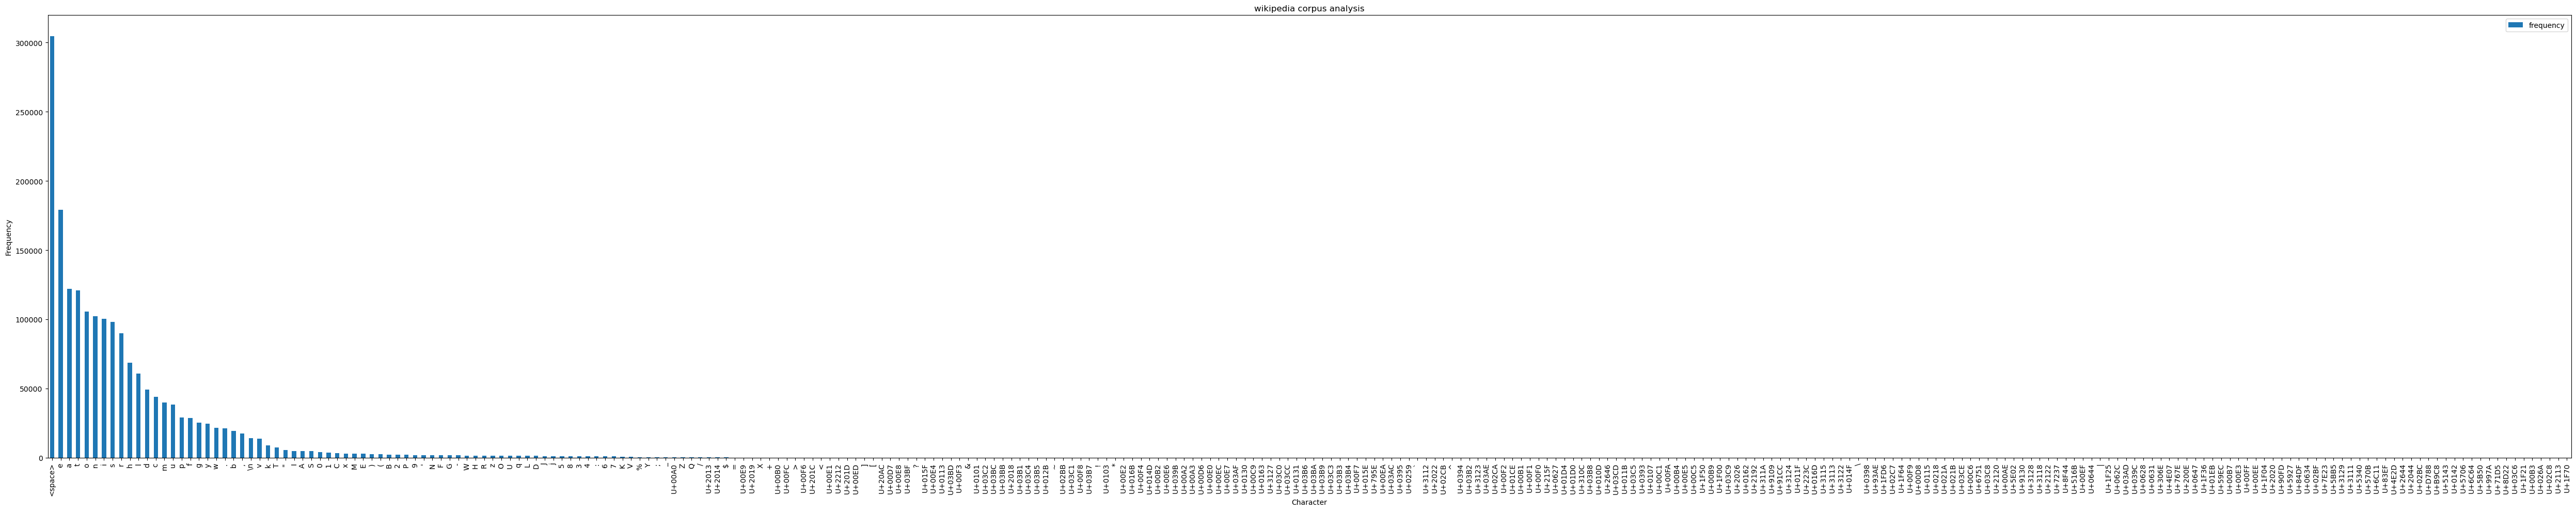

,frequency
<space>,304595
e,179311
a,122140
t,120734
o,105490
n,102326
i,100171
s,98279
r,89870
h,68633


In [ ]:
#Character Analysis for each corpus of text
import collections
import pandas as pd
import matplotlib.pyplot as plt

def safe_label(c):
    if c == '\n':
        return '\\n'
    if c ==' ':
        return '<space>'
    try:
        c.encode("ascii")
        return c
    except UnicodeEncodeError:
        return f"U+{ord(c):04X}"


corpus_freq = collections.Counter(text)


df = pd.DataFrame.from_dict(corpus_freq, orient='index', columns=['frequency'])
df = df.sort_values(by='frequency', ascending=False)
df.index = [safe_label(c) for c in df.index] # Replace with unicode character incase it is a non ascii character
unicode_df = df[df.index.str.startswith('U+')]
df.plot(kind='bar', figsize=(50,10), width=0.5)
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.title(f'{corpus_name} corpus analysis')
plt.tight_layout()
plt.savefig(f'{corpus_name}_barchart.png') 
plt.show()
df.head(50)

(200, 1)
        frequency
U+00A0        233
U+2013        135
U+2014        112
U+00E9         68
U+2019         59
U+00B0         52
U+00FC         46
U+00F6         42
U+201C         41
U+00E1         38
U+2212         37
U+201D         35
U+00ED         33
U+20AC         25
U+00D7         22
U+00E8         20
U+03BF         20
U+015F         18
U+00E4         16
U+0113         16


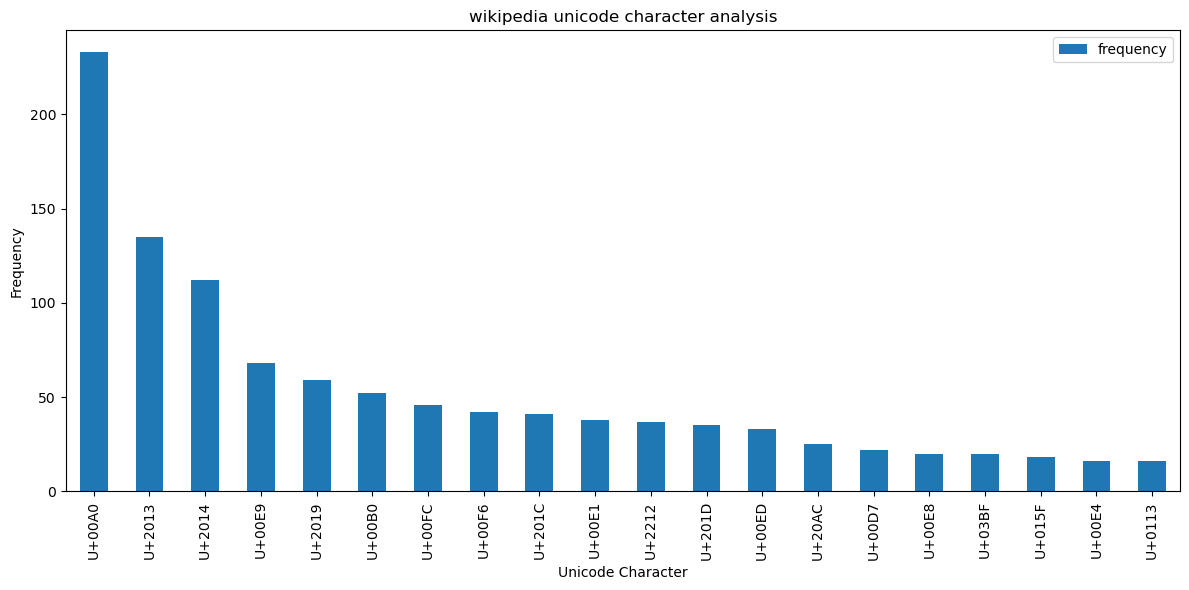

In [174]:
print(unicode_df.shape)
if unicode_df.empty:
    print(f'Corpus {corpus_name} does not contain unicode characters')
    unicode_df.to_csv(f'{corpus_name}_unicode_characters.txt',header=False)\

else:
    unicode_df = unicode_df.head(20)
    unicode_df.plot(kind='bar', figsize=(12,6), width=0.5)
    plt.xlabel('Unicode Character')
    plt.ylabel('Frequency')
    plt.title(f'{corpus_name} unicode character analysis')
    plt.tight_layout()
    plt.savefig(f'{corpus_name}_unicode_barchart.png') # Save as png image
    print(unicode_df)
    unicode_df.to_csv(f'{corpus_name}_unicode_characters.txt',header=False)

In [151]:
from nanogpt_model import GPT  # Import the GPT model class from the NanoGPT repo


# -----------------------------------------
# Define a configuration object for the GPT model
# -----------------------------------------
class GPTConfig:
    def __init__(self, vocab_size, block_size,
                 n_layer=2, n_head=2, n_embd=128, dropout=0.0, bias = True):
        """
        This class is a container for all the key hyperparameters
        that define the size and shape of the GPT model.
        We pass this config into the GPT constructor so the model
        can be built with these exact settings.

        ---------------------------
        Parameter meanings:
        ---------------------------

        vocab_size:
            - Number of unique tokens in our dataset.
            - In a character-level model, this is the number of distinct characters.
            - Maps directly to the size of the token embedding matrix:
                token_embedding_table.shape == (vocab_size, n_embd)

        block_size:
            - Maximum context length (sequence length) the model sees at once.
            - Sets the width of the positional embedding table:
                position_embedding_table.shape == (block_size, n_embd)
            - Also defines the mask size in self-attention so the model only attends
              to the last `block_size` tokens.

        n_layer:
            - Number of Transformer blocks stacked in the model.
            - Each block = (Multi-Head Self-Attention + Feedforward MLP + LayerNorm).
            - More layers allow the model to capture more complex dependencies.

        n_head:
            - Number of attention heads per multi-head attention layer.
            - Each head learns to focus on different positions/tokens in the sequence.
            - Heads are concatenated then projected back into `n_embd` dimensions.

        n_embd:
            - Dimensionality of token embeddings and all hidden states.
            - Controls the "width" of the model.
            - Affects:
                * Token embedding size
                * Positional embedding size
                * Per-head dimension in attention: head_dim = n_embd / n_head
                * Hidden size of the feedforward layers in each block.

        dropout:
            - Dropout probability applied in various places (attention, MLP) during training.
            - Helps prevent overfitting by randomly zeroing activations.
 
        """

        # Store all parameters for use by the GPT class
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_layer = n_layer
        self.n_head = n_head
        self.n_embd = n_embd
        self.dropout = dropout 
        self.bias = bias  
print(block_size)
config = GPTConfig(vocab_size=dataset.vocab_size, block_size=block_size)
model = GPT(config)
print(model)

 

64
number of parameters: 0.43M
GPT(
  (transformer): ModuleDict(
    (wte): Embedding(292, 128)
    (wpe): Embedding(64, 128)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-1): 2 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=128, out_features=384, bias=True)
          (c_proj): Linear(in_features=128, out_features=128, bias=True)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=128, out_features=512, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=512, out_features=128, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=128, out_features=292, bias=False)
)


 

## Analysis: Model Architecture Diagram
 
Create a clear, labeled diagram of the NanoGPT model you trained, showing the **flow of data** from input to output, including the **shapes/dimensions** at each stage. Do this *by hand*. You may use a tablet, but it cannot look code-generated. 

 
1. **Overall Layout**

   * Show the full pipeline:
     **Input Tokens → Token Embedding → Positional Embedding → Transformer Blocks → LayerNorm → Output Head → Softmax**.

2. **Transformer Blocks**

   * Each block should include:

     * **LayerNorm 1 → Multi-Head Causal Self-Attention → Residual Connection**
     * **LayerNorm 2 → Feedforward MLP → Residual Connection**
   * Clearly label these sub-components and indicate that this block repeats `n_layer` times.

3. **Dimensions**

   * Label the **shape** of the tensor at each stage (batch size = `B`, sequence length = `T`, embedding size = `n_embd`):

     * Input: `(B, T)` (integer token IDs)
     * Token embeddings: `(B, T, n_embd)`
     * After adding positional embeddings: `(B, T, n_embd)`
     * Inside attention: queries/keys/values → `(B, n_head, T, head_dim)`
     * MLP layers: `(B, T, 4*n_embd)` then back to `(B, T, n_embd)`
     * Output logits: `(B, T, vocab_size)`

4. **Connections**

   * Draw arrows between each component to show the data flow.
   * Mark residual connections that add the block’s input to its output.

5. **Label Hyperparameters**

   * Include:

     * `n_layer` = number of transformer blocks
     * `n_head` = number of attention heads per block
     * `n_embd` = embedding dimension
     * `block_size` = maximum context length
     * `vocab_size` = size of the token vocabulary

6. **Final Output**

   * Show that the model outputs logits for each token position, then a softmax over the vocabulary to get probabilities.

 
 

 

## Training NanoGPT

The following code actually **trains NanoGPT** on your selected dataset.
Your job is to:

1. **Play around with the hyperparameters** (e.g. learning rate, batch size, context length, number of layers).
2. **Run the training loop** long enough to get meaningful results.
3. **Save a trained checkpoint for each of the three corpora** (`shakespeare`, `wikipedia`, `math`).
 
After training:

* You should have a folder of checkpoints (e.g. `checkpoints/shakespeare/final.pt`).
* Each corpus will give you a slightly different “voice” when you generate text.
 

In [ ]:
import os
import torch
from tqdm import tqdm
print(corpus_name)
# Directory for this corpus
ckpt_dir = os.path.join("checkpoints", corpus_name)
os.makedirs(ckpt_dir, exist_ok=True)
final_ckpt_path = os.path.join(ckpt_dir, "final.pt")

if os.path.exists(final_ckpt_path):
    print(f"Final checkpoint for '{corpus_name}' found at {final_ckpt_path}.")
    ckpt = torch.load(final_ckpt_path, map_location="cpu")
    model.load_state_dict(ckpt["model_state"])
    losses = ckpt.get("losses", [])
    print(f"Loaded model with {len(losses)} stored loss values.")
else:
    print(f"No checkpoint found for '{corpus_name}', starting training...")
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    max_iters = 15000

    losses = []
    model.train()
    for it in range(max_iters):
        xb, yb = next(iter(loader))

        logits, loss = model(xb, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if it % 100 == 0:
            model.eval()
            eval_losses = []
            
            max_batches = len(loader) * 0.01
            for i, (xb_eval, yb_eval) in enumerate(loader):
                if i >= max_batches:  break
                logits_eval, loss_eval = model(xb_eval, yb_eval)
                eval_losses.append(loss_eval.item())
            avg_loss = torch.mean(torch.tensor(eval_losses))
            losses.append(avg_loss)
            print(f"Iter {it}/{max_iters}, Avg Loss over dataset: {avg_loss:.4f}")

            iter_ckpt_path = os.path.join(ckpt_dir, f"iter_{it}.pt")
            torch.save({
                "model_state": model.state_dict(),
                "config": config.__dict__,
                "itos": dataset.itos,
                "stoi": dataset.stoi,
                "losses": losses
            }, iter_ckpt_path)
            print(f"Saved checkpoint: {iter_ckpt_path}")
            model.train()

    torch.save({
        "model_state": model.state_dict(),
        "config": config.__dict__,
        "itos": dataset.itos,
        "stoi": dataset.stoi,
        "losses": losses
    }, final_ckpt_path)
    print(f"Saved final model to {final_ckpt_path}")


math
No checkpoint found for 'math', starting training...
Iter 0/15000, Avg Loss over dataset: 4.1666
Saved checkpoint: checkpoints/math/iter_0.pt
Iter 100/15000, Avg Loss over dataset: 2.6317
Saved checkpoint: checkpoints/math/iter_100.pt
Iter 200/15000, Avg Loss over dataset: 2.4378
Saved checkpoint: checkpoints/math/iter_200.pt
Iter 300/15000, Avg Loss over dataset: 2.2738
Saved checkpoint: checkpoints/math/iter_300.pt
Iter 400/15000, Avg Loss over dataset: 2.1431
Saved checkpoint: checkpoints/math/iter_400.pt
Iter 500/15000, Avg Loss over dataset: 2.0506
Saved checkpoint: checkpoints/math/iter_500.pt
Iter 600/15000, Avg Loss over dataset: 1.9611
Saved checkpoint: checkpoints/math/iter_600.pt
Iter 700/15000, Avg Loss over dataset: 1.8722
Saved checkpoint: checkpoints/math/iter_700.pt
Iter 800/15000, Avg Loss over dataset: 1.8210
Saved checkpoint: checkpoints/math/iter_800.pt
Iter 900/15000, Avg Loss over dataset: 1.7650
Saved checkpoint: checkpoints/math/iter_900.pt
Iter 1000/15000,

## Analysis: Track Model Output Over Training


### **Procedure**
* Extract model checkpoints every **100 iterations** (e.g., `iter_100.pt`, `iter_200.pt`, `iter_300.pt`, …).
* For each corpus (`shakespeare`, `wikipedia`, `math`):
 * Use the provided generation code to produce **one line of generated text** from the **same fixed prompt** (e.g., `"Once upon a time"`).
 * If you find the output has not yet achieved the langauge structure quality you desire, you may want to train it for longer. Go until you have a strong model.

---

### **Consistency**

* Keep the **prompt** identical across all checkpoints, but consistent to the corpora in mind.
* Use the same **number of generated tokens** each time.
* This ensures you can make direct comparisons between outputs.

---

### **Reporting**

In your lab report:

* Include a short **table or list** for each corpus showing:

  * Iteration number.
  * The generated output (first \~100 characters).

* Discuss the following:

  * At what point does the text start to look coherent?
  * How does the style differ between Shakespeare, Wikipedia, and Math?
  * Does the model become **overconfident** (repetitive text, fixed patterns) at later stages?

In [84]:
import os

# This code loads a specific training checkpoint of NanoGPT
# (saved during training) and uses it to generate text.


def generate_small_text(corpus, start_text, iteration_to_load, max_new_tokens):
    # Path to the specific checkpoint
    
    if iteration_to_load == "final":
        ckpt_path = os.path.join("checkpoints", corpus, "final.pt")
    else:
        ckpt_path = os.path.join("checkpoints", corpus, f"iter_{iteration_to_load}.pt")
    
    if not os.path.exists(ckpt_path):
        print(f"Checkpoint {ckpt_path} not found. Make sure to train first.")
    else:
        # Load checkpoint from disk
        ckpt = torch.load(ckpt_path, map_location="cpu")
    
        # Rebuild the GPT model from saved config
        loaded_config = type("GPTConfig", (), ckpt["config"])
        gen_model = GPT(loaded_config)
        gen_model.load_state_dict(ckpt["model_state"])
        gen_model.eval()
    
        # Tokenization: convert characters to IDs
        stoi = ckpt["stoi"]
        itos = ckpt["itos"]
        idx = torch.tensor([stoi.get(c, 0) for c in start_text], dtype=torch.long).unsqueeze(0)
    
        # Autoregressive generation loop
        with torch.no_grad():
            for _ in range(max_new_tokens):
                # Feed only the last block_size tokens
                idx_cond = idx[:, -loaded_config.block_size:]
                logits, _ = gen_model(idx_cond)
    
                # Convert logits to probabilities
                probs = torch.softmax(logits[:, -1, :], dim=-1)
    
                # Sample next token from probability distribution
                idx_next = torch.multinomial(probs, num_samples=1)
    
                # Append new token to the sequence
                idx = torch.cat((idx, idx_next), dim=1)
    
        # Decode IDs back into text
        generated_text = ''.join([itos[i.item()] for i in idx[0]])
        return generated_text

In [ ]:
#Generate text 
# generate_small_text('math', 'Coordinate geometry is', 'final', 200)

corpora = ['shakespeare', 'wikipedia', 'math']

prompts = {
    "shakespeare": "ACT I SCENE I",
    "wikipedia": "In this region",
    "math": "Coordinate geometry"
}

checkpoints = [iter_number for iter_number in range(100,15000,100)]
checkpoints.append("final")
new_tokens=200

for corpus in corpora:
    results = []
    
    for checkpoint in checkpoints:
        result = generate_small_text(corpus, prompts[corpus], checkpoint, new_tokens)
        results.append((f"{corpus}_{checkpoint}",result[:150]))
    
    results_filename = f"{corpus}_results.txt"
    with open(results_filename,"w",encoding="utf-8") as f:
        for checkpoint,text in results:
            f.write(f"=== {checkpoint} ===\n")
            f.write(text)
            f.write("\n\n")



/var/folders/j8/1sz861yd0glbtfxp4_p070qc0000gn/T/ipykernel_80006/2355295863.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c

number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters

## Analysis: Variability of the Final Model

### **Procedure**

* After training, take the **final checkpoint** for each corpus.
* Using the same prompt as before (corpus-consistent), generate **multiple outputs (at least 5)**.
* Each output should use the same number of tokens, so they are directly comparable.

---

### **Consistency**

* Keep the prompt identical across all generations for each corpus.
* Do not change model parameters, only re-run generation.

---

### **Reporting**

In your lab report:

* Include the set of generated outputs from the final model.
* Comment on:

  * The **variance** across outputs: do they differ in interesting ways, or are they repetitive?
  * Whether the variability seems to capture the **style** of the corpus.
  * Whether you are satisfied with the outputs: does it feel like the model “learned” something meaningful?



In [ ]:
#Generating 5 outputs using the final model
for corpus in corpora:
    results = []
    for i in range(1,6):
        ans = generate_small_text(corpus,prompts[corpus],'final',200)
        results.append((f'Generation {i}',ans))
    results_filename = f"{corpus}_finalmodel_generation.txt"
    with open(results_filename,"w",encoding="utf-8") as f:
        for generation,text in results:
            f.write(f"=== {generation} ===\n")
            f.write(text)
            f.write("\n\n")

/var/folders/j8/1sz861yd0glbtfxp4_p070qc0000gn/T/ipykernel_80006/2355295863.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c

number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M




## **Analysis: Plot Training Loss from Checkpoints**ble**

* Produce **one loss curve plot per corpus** (`shakespeare`, `wikipedia`, `math`).
* Compare and contrast the training behavior across the different corpora.

**What to Comment On**

* Identify which loss values seem to correspond to **qualitatively good performance** (e.g., when the model starts producing coherent, domain-appropriate text).
* Note that the **initial drop in loss** is often not enough: real quality emerges only once the model reaches **very low error**.
* Discuss differences across corpora:

  * Which corpus needed lower loss values before outputs became convincing?
  * Do some domains “sound good” ons for what to hand in)?


/var/folders/j8/1sz861yd0glbtfxp4_p070qc0000gn/T/ipykernel_80006/2612890822.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path_to_final_model, map_lo

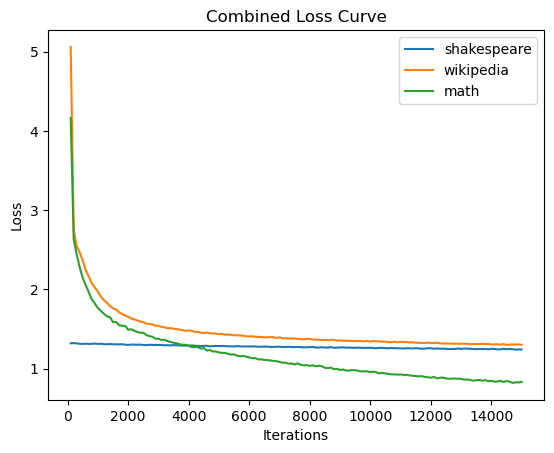

In [ ]:
#Plotting Loss curves for each corpus
for corpus in corpora:
    path_to_final_model = os.path.join("checkpoints", corpus, "final.pt")
    if not path_to_final_model:
        print("Final model missing")
    else:
        ckpt = torch.load(path_to_final_model, map_location="cpu")
        losses = ckpt.get("losses")
        xaxis = [i*100 for i in range(1,len(losses)+1)]
        plt.clf()
        plt.plot(xaxis,losses,label=corpus)
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.title(f"{corpus} Loss Curve")
        plt.legend()
        curve_filename = f"{corpus}_loss_curve.png"
        plt.savefig(curve_filename)      

## **Part 2 – Cross-Domain Evaluation**

* Evaluate each trained model **on each other’s dataset**:

  * **Zero-shot**: Direct prompt without domain examples.
  * **Few-shot**: Include 1–3 in-domain examples in the prompt.
* Compare:

  * Loss in-domain vs. out-of-domain.
  * Quality and relevance of generated continuations.





# Detailed Instructions

### **Part 2 Step 1: Zero-shot Evaluation**

For each dataset pair (A, B) where A, B ∈ {`wikipedia`, `math`, `shakespeare`}:

1. Load the **final checkpoint** of the model trained on A.

   * When rebuilding the model, you must restore the **vocab size** from the checkpoint, e.g.

     ```python
     vocab_size = len(ckpt["stoi"])
     model = GPT(vocab_size=vocab_size)
     ```
   * This ensures the embedding and output layers match the original training.
2. Evaluate it on dataset B **without in-domain examples**. Do so on 1% of the training data, as it is very large.
3. Record the **loss values** in a 3×3 table (diagonal = in-domain).
4. For each pair, include one **generated sample** with these instructions?


In [ ]:
import os, math, random
import torch
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
BATCH_SIZE = 32
FRACTION_OF_DATA = 0.01


corpora = ["shakespeare", "wikipedia", "math"]
prompts = {
    "shakespeare": "ACT I SCENE I",
    "wikipedia": "In this region",
    "math": "Coordinate geometry"
}

In [ ]:
def load_model_for_corpus(corpus):
    checkpoint_path = os.path.join("checkpoints",corpus,"final.pt")
    ckpt = torch.load(checkpoint_path, "cpu")
    stoi = ckpt["stoi"] 
    vocab_size = len(stoi)
    config = ckpt["config"]
    config = GPTConfig(vocab_size=vocab_size, block_size=64)
    model = GPT(config)
    model.load_state_dict(ckpt["model_state"])
    return model, stoi, 64

def read_data_from_file(corpus_name):
    with open(f"data/{corpus_name}.txt", mode="r", encoding="utf-8") as f:
        return f.read()

def encode_with_stoi(text,stoi):
    return torch.tensor([stoi[c] for c in text if c in stoi], dtype=torch.long)

def find_loss_on_subset(model, dataset, fraction=FRACTION_OF_DATA, batch_size=32):
    n = len(dataset)
    use_n = max(1, int(math.ceil(n * fraction)))
    subset = torch.utils.data.Subset(dataset, range(use_n))
    loader = DataLoader(subset, batch_size=32, shuffle=False)

    model.eval().to("cpu")
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to("cpu"), yb.to("cpu")
            _, loss = model(xb, yb)
            losses.append(loss.item())
    return sum(losses) / len(losses)

def make_dataset(token_ids):
    xs, ys = [], []
    for i in range(0, len(token_ids)-64):
        xs.append(token_ids[i:i+block_size])
        ys.append(token_ids[i+1:i+1+block_size])
    return TensorDataset(torch.stack(xs), torch.stack(ys))


In [ ]:
loss_matrix = pd.DataFrame(index=corpora, columns=corpora, dtype=float)
text_generated = []

for A in corpora:
    modelA, stoiA, blockA = load_model_for_corpus(A)
    for B in corpora:
        textB = read_data_from_file(B)
        idsB = encode_with_stoi(textB, stoiA)
        dsB = make_dataset(idsB)
        lossAB = find_loss_on_subset(modelA, dsB)
        loss_matrix.loc[A,B] = lossAB
        print(f"A={A} → B={B}: loss={lossAB:.4f}")

        promptB = prompts[B]
        modelA.eval().to("cpu")
        with torch.no_grad():
            response = generate_small_text(A, promptB,"final", 400)
            text_generated.append(f"=== A={A} → B={B} ===\nPrompt: {promptB}\n{response}\n")

loss_matrix.to_csv("zero_shot_loss.csv", float_format="%.4f", index_label="source")
with open("zero_shot_samples.txt", "w", encoding="utf-8") as f:
    f.write("\n".join(text_generated))


/var/folders/j8/1sz861yd0glbtfxp4_p070qc0000gn/T/ipykernel_62308/4094720731.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, "cpu")


number of parameters: 0.41M
A=shakespeare → B=shakespeare: loss=1.2639
number of parameters: 0.41M
A=shakespeare → B=wikipedia: loss=2.3736
number of parameters: 0.41M
A=shakespeare → B=math: loss=4.2455
number of parameters: 0.41M
number of parameters: 0.43M
A=wikipedia → B=shakespeare: loss=2.3239
number of parameters: 0.43M
A=wikipedia → B=wikipedia: loss=1.2473
number of parameters: 0.43M
A=wikipedia → B=math: loss=2.7215
number of parameters: 0.43M
number of parameters: 0.41M
A=math → B=shakespeare: loss=4.4862
number of parameters: 0.41M
A=math → B=wikipedia: loss=3.6598
number of parameters: 0.41M
A=math → B=math: loss=0.8232
number of parameters: 0.41M


### **Part 2 Step 2: Few-shot Evaluation**

1. **Start from a Pretrained Model (Dataset A).**

   * Choose a model that has already been trained on dataset **A** (e.g., `wikipedia`, `math`, `shakespeare`).
   * Load the **final checkpoint** for A:

     ```python
     ckpt_path = f"checkpoints/{A}/final.pt"
     ckpt = torch.load(ckpt_path, map_location="cpu")
     ```
   * Important: the vocabulary size used for training A may differ from the default.

     * Before building the model, set

       ```python
       config.vocab_size = len(ckpt["stoi"])
       model = GPT(config)
       ```
     * This ensures the embedding and output layer dimensions match the checkpoint.
   * Finally, load the weights:

     ```python
     model.load_state_dict(ckpt["model_state"])
     ```

2. **Fine-tune on Dataset B.**

   * Use the **same vocabulary (`stoi`, `itos`) from dataset A** to enco0de dataset B.
   * Train for **200 iterations** with AdamW (`lr=**10, 25, 50, 100, 2ns thereafter if you extend training.
   * Naming convention:

     ```
     {A}_start{N}_{B}_run{M}.pt
     ```

     where

     * **A** = source dataset (e.g. `wikipedia`)
     * **B** = target dataset (e.g. `math`)
     * **N** = starting iteration (e.g. `0` if from scratch, or `500` if resuming)
     * **M** = current fine-tuning iteration

3. **Evaluate and Track Loss.**

   * Every 50 steps, evaluate on a **1% subsample of dataset B** for speed.
   * Record the average evaluation loss.
   * Keep a running list of these evaluation losses to plot later.

4. **Plot Loss Curves.**

   * After training, plot **loss vs iteration** for each experiment.
   * Compare curves across different (A→B) fine-tuning runs.
   * This shows how quickly and effectively each pretrained model adapts to dataset B.

5. **Examples**

   * At each saved checkpoint (10, 25, 50, 100, 200), generate short text continuations from the model.
   * Use the same sampling routine (temperature-controlled decoding).
   * Collect and compare generations to see how quality improves over fiations at checkpoints), so the students can just fill in dataset names?
heckpoints), so the students can just fill in dataset names?


In [ ]:
A = "wikipedia"
B = "math"
EPOCHS = 200
EVAL_EVERY  = 50
SAVE_STEPS  = [10, 25, 50, 100, 200]
FRACTION_B  = 0.01

BATCH_SIZE  = 32
LR          = 3e-4

prompts = {
    "shakespeare": "ACT I SCENE I",
    "wikipedia": "In this region",
    "math": "Coordinate geometry"
}

import os
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


def read_text(name):
    with open(f"data/{name}.txt","r",encoding="utf-8") as f:
        return f.read()

def encode_chars(text, stoi):
    return torch.tensor([stoi[c] for c in text if c in stoi], dtype=torch.long)

def make_dataset(ids, block_size):
    n = len(ids)
    if n <= block_size:
        X = torch.zeros((1, block_size), dtype=torch.long)
        Y = torch.zeros((1, block_size), dtype=torch.long)
        return TensorDataset(X, Y)
    X, Y = [], []
    for i in range(n - block_size):
        X.append(ids[i:i+block_size])
        Y.append(ids[i+1:i+1+block_size])
    return TensorDataset(torch.stack(X), torch.stack(Y))

@torch.no_grad()
def generate_with_model(model, stoi, itos, prompt, max_new_tokens=120, temperature=1.0):
    unk = next(iter(stoi.values()))
    x = torch.tensor([[stoi.get(c, unk) for c in prompt]], dtype=torch.long, device="cpu")
    bs = model.config.block_size
    if x.size(1) > bs: x = x[:, -bs:]
    for _ in range(max_new_tokens):
        logits, _ = model(x)
        logits = logits[:, -1, :] / max(1e-6, temperature)
        probs  = torch.softmax(logits, dim=-1)
        nxt    = torch.multinomial(probs, 1)
        x = torch.cat([x, nxt], 1)
        if x.size(1) > bs: x = x[:, -bs:]
    return "".join(itos[int(t)] for t in x[0].tolist())


In [ ]:
ckptA_path = os.path.join("checkpoints", A, "final.pt")
ckptA = torch.load(ckptA_path, map_location="cpu")
stoiA, itosA = ckptA["stoi"], ckptA["itos"]
vocab_size   = len(stoiA)

config = GPTConfig(vocab_size=vocab_size, block_size=64)
model  = GPT(config).to("cpu")
model.load_state_dict(ckptA["model_state"])
model.train()

block_size = config.block_size
print(f"Loaded A='{A}' | vocab={vocab_size} | block_size={block_size}")

textB     = read_text(B)
idsB_full = encode_chars(textB, stoiA)
train_dsB = make_dataset(idsB_full, block_size)

keep      = max(block_size + 1, int(len(idsB_full) * FRACTION_B))
eval_dsB  = make_dataset(idsB_full[:keep], block_size)

optimizer   = torch.optim.AdamW(model.parameters(), lr=LR)
train_loader= DataLoader(train_dsB, batch_size=32, shuffle=True, drop_last=True)
it_loader   = iter(train_loader)

exp_dir = os.path.join("few_shot", f"{A}_to_{B}")

loss_hist, eval_x, eval_y = [], [], []

def eval_on_subset(model, ds, bs=32):
    model.eval()
    L = []
    with torch.no_grad():
        for xb, yb in DataLoader(ds, batch_size=bs, shuffle=False):
            xb, yb = xb.to("cpu"), yb.to("cpu")
            _, loss = model(xb, yb)
            L.append(loss.item())
    model.train()
    return sum(L)/len(L)

#initial evaluation for zero shot
ev0 = eval_on_subset(model, eval_dsB)
eval_x, eval_y = [0], [ev0]
print(f"[{A}->{B}] step=   0 eval1%={ev0:.4f}")

for step in range(1, EPOCHS+1):
    try:
        xb, yb = next(it_loader)
    except StopIteration:
        it_loader = iter(train_loader)
        xb, yb = next(it_loader)

    xb, yb = xb.to("cpu"), yb.to("cpu")
    optimizer.zero_grad()
    _, loss = model(xb, yb)
    loss.backward(); optimizer.step()
    loss_hist.append(loss.item())

    if step % EVAL_EVERY == 0:
        ev = eval_on_subset(model, eval_dsB)
        eval_x.append(step); eval_y.append(ev)
        print(f"[{A}->{B}] step={step:4d} train={loss.item():.4f} eval1%={ev:.4f}")

    if step in SAVE_STEPS:
        save_path = os.path.join(exp_dir, f"{A}_start0_{B}_run{step}.pt")
        torch.save({
            "model_state": model.state_dict(),
            "stoi": stoiA, "itos": itosA,
            "config": {"vocab_size": vocab_size, "block_size": block_size},
            "meta": {"A": A, "B": B, "step": step}
        }, save_path)
        print(f"[saved] {save_path}")

pd.DataFrame({"step": list(range(1, EPOCHS+1)), "train_loss": loss_hist}) \
  .to_csv(os.path.join(exp_dir, f"train_loss_{A}_to_{B}.csv"), index=False)
pd.DataFrame({"step": eval_x, "eval_loss_1pct": eval_y}) \
  .to_csv(os.path.join(exp_dir, f"eval1pct_{A}_to_{B}.csv"), index=False)


/var/folders/j8/1sz861yd0glbtfxp4_p070qc0000gn/T/ipykernel_62308/1222226061.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckptA = torch.load(ckptA_path, map_location="

number of parameters: 0.43M
Loaded A='wikipedia' | vocab=292 | block_size=64
[wikipedia->math] step=   0 eval1%=2.7379
[saved] few_shot/wikipedia_to_math/wikipedia_start0_math_run10.pt
[saved] few_shot/wikipedia_to_math/wikipedia_start0_math_run25.pt
[wikipedia->math] step=  50 train=1.9457 eval1%=2.1394
[saved] few_shot/wikipedia_to_math/wikipedia_start0_math_run50.pt
[wikipedia->math] step= 100 train=1.5508 eval1%=2.0569
[saved] few_shot/wikipedia_to_math/wikipedia_start0_math_run100.pt
[wikipedia->math] step= 150 train=1.7107 eval1%=2.0182
[wikipedia->math] step= 200 train=1.7094 eval1%=1.9788
[saved] few_shot/wikipedia_to_math/wikipedia_start0_math_run200.pt


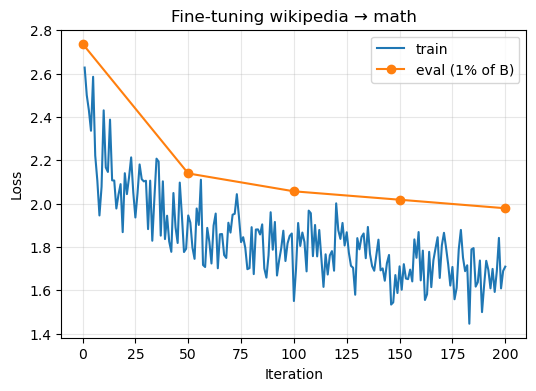

/var/folders/j8/1sz861yd0glbtfxp4_p070qc0000gn/T/ipykernel_62308/2799707808.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cp  = torch.load(path, map_location="cpu")


number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
number of parameters: 0.43M
[saved] few_shot/wikipedia_to_math/samples_wikipedia_to_math.md


In [ ]:
# plot loss
plt.figure(figsize=(6,4))
plt.plot(range(1, EPOCHS+1), loss_hist, label="train")
if eval_x:
    plt.plot(eval_x, eval_y, marker="o", label="eval (1% of B)")
plt.xlabel("Iteration"); plt.ylabel("Loss")
plt.title(f"{A}->{B}")
plt.grid(True, alpha=0.3); plt.legend()
plt.savefig(os.path.join(exp_dir, f"loss_curves_{A}_to_{B}.png"), bbox_inches="tight", dpi=150)
plt.show()

md_path = os.path.join(exp_dir, f"samples_{A}_to_{B}.md")
lines = [f"# Samples: {A} → {B}", ""]
for step in SAVE_STEPS:
    path = os.path.join(exp_dir, f"{A}_start0_{B}_run{step}.pt")
    if not os.path.exists(path): 
        continue
    cp  = torch.load(path, map_location="cpu")
    cfg = GPTConfig(vocab_size=len(cp["stoi"]), block_size=cp["config"]["block_size"])
    m   = GPT(cfg).to("cpu"); m.load_state_dict(cp["model_state"]); m.eval()
    txt = generate_with_model(m, cp["stoi"], cp["itos"], prompts[B], max_new_tokens=120, temperature=1.0)
    lines += [f"## {os.path.basename(path)}", "", f"**Prompt**: {prompts[B]}", "", "```", txt, "```", ""]

with open(md_path, "w", encoding="utf-8") as f:
    f.write("\n".join(lines))
print(f"[saved] {md_path}")


## **Part 2 Step 3: Few-shot from Earlier Checkpoints**

* Repeat Step 2, but start from models that were **not fully trained** on A.
* Compare results: does partial training make adaptation easier? 


=== Loading A='wikipedia' checkpoint: checkpoints/wikipedia/iter_500.pt ===
number of parameters: 0.43M


/var/folders/j8/1sz861yd0glbtfxp4_p070qc0000gn/T/ipykernel_62308/1533138998.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt=torch.load(ckpt_path, map_location="cpu

[wikipedia start500->math] step=0 eval=3.3224
[saved & generated] wikipedia_start500_math_run10.pt
[saved & generated] wikipedia_start500_math_run25.pt
step=  50 train=2.3727 eval=2.7345
[saved & generated] wikipedia_start500_math_run50.pt
step= 100 train=2.3130 eval=2.6448
[saved & generated] wikipedia_start500_math_run100.pt
step= 150 train=2.1665 eval=2.6237
step= 200 train=2.1976 eval=2.5653
[saved & generated] wikipedia_start500_math_run200.pt

=== Loading A='wikipedia' checkpoint: checkpoints/wikipedia/iter_5000.pt ===
number of parameters: 0.43M
[wikipedia start5000->math] step=0 eval=2.6812
[saved & generated] wikipedia_start5000_math_run10.pt
[saved & generated] wikipedia_start5000_math_run25.pt
step=  50 train=1.8882 eval=2.2111
[saved & generated] wikipedia_start5000_math_run50.pt
step= 100 train=1.6531 eval=2.1162
[saved & generated] wikipedia_start5000_math_run100.pt
step= 150 train=1.7860 eval=2.0785
step= 200 train=1.5425 eval=2.0483
[saved & generated] wikipedia_start50

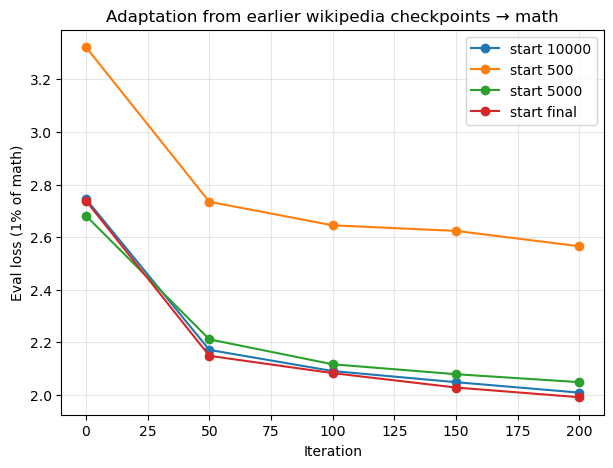

[saved plot] few_shot/wikipedia_math/part2step3/wikipedia_to_math_compare.png


In [ ]:
import os, torch, pandas as pd, matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

A = "wikipedia" 
B = "math"

RUN_STEPS = 200
EVAL_EVERY = 50
SAVE_STEPS = [10, 25, 50, 100, 200]
FRACTION_B = 0.01
LR = 3e-4

STARTS = {
    "500": f"checkpoints/{A}/iter_500.pt",
    "5000": f"checkpoints/{A}/iter_5000.pt",
    "10000": f"checkpoints/{A}/iter_10000.pt",
    "final": f"checkpoints/{A}/final.pt"
}

prompts = {
    "shakespeare": "ACT I SCENE I",
    "wikipedia": "In this region",
    "math": "Coordinate geometry"
}

OUT_ROOT = os.path.join("few_shot", f"{A}_{B}", "part2step3")

def read_text(name):
    with open(f"data/{name}.txt","r",encoding="utf-8") as f:
        return f.read()

def encode_chars(text, stoi):
    return torch.tensor([stoi[c] for c in text if c in stoi], dtype=torch.long)

#encoding dataset like part2
def make_dataset(ids, block_size):
    n=len(ids)
    if n <= block_size:
        X = torch.zeros((1, block_size), dtype=torch.long)
        Y = torch.zeros((1, block_size), dtype=torch.long)
        return TensorDataset(X, Y)
    X,Y=[],[]
    for i in range(n - block_size):
        X.append(ids[i:i+block_size]); Y.append(ids[i+1:i+1+block_size])
    return TensorDataset(torch.stack(X), torch.stack(Y))

@torch.no_grad()
def eval_on_subset(model, ds):
    model.eval(); L=[]
    for xb,yb in DataLoader(ds, batch_size=32, shuffle=False):
        xb,yb=xb.to("cpu"), yb.to("cpu")
        _, loss = model(xb,yb); L.append(loss.item())
    model.train(); return sum(L)/len(L) if L else float('nan')

def load_model_ckpt(ckpt_path, block_size=64):
    ckpt=torch.load(ckpt_path, map_location="cpu")
    stoi, itos = ckpt["stoi"], ckpt["itos"]
    cfg = GPTConfig(vocab_size=len(stoi), block_size=block_size)
    model = GPT(cfg).to("cpu"); model.load_state_dict(ckpt["model_state"]); model.train()
    return model, stoi, itos, cfg.block_size

@torch.no_grad()
def generate_with_model(model, stoi, itos, prompt, max_new_tokens=120, temperature=1.0):
    unk = next(iter(stoi.values()))
    x = torch.tensor([[stoi.get(c, unk) for c in prompt]], dtype=torch.long, device="cpu")
    bs = model.config.block_size
    if x.size(1) > bs: x = x[:, -bs:]
    for _ in range(max_new_tokens):
        logits, _ = model(x)
        logits = logits[:, -1, :] / max(1e-6, temperature)
        probs  = torch.softmax(logits, dim=-1)
        nxt    = torch.multinomial(probs, 1)
        x = torch.cat([x, nxt], 1)
        if x.size(1) > bs: x = x[:, -bs:]
    return "".join(itos[int(t)] for t in x[0].tolist())

gen_lines = []

for startN, path in STARTS.items():
    print(f"\n=== Loading A='{A}' checkpoint: {path} ===")
    if not os.path.exists(path):
        print("[skip] missing"); continue
    model, stoiA, itosA, block_size = load_model_ckpt(path)

    idsB = encode_chars(read_text(B), stoiA)
    train_ds = make_dataset(idsB, block_size)

    keep     = max(block_size+1, int(len(idsB)*FRACTION_B))
    eval_ds  = make_dataset(idsB[:keep], block_size)

    opt = torch.optim.AdamW(model.parameters(), lr=LR)
    loader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
    it_loader = iter(loader)

    # Initial eval for step 0
    eval_x, eval_y = [0], [eval_on_subset(model, eval_ds)]
    print(f"[{A} start{startN}->{B}] step=0 eval={eval_y[-1]:.4f}")

    train_hist = []
    for step in range(1, RUN_STEPS+1):
        try: xb,yb = next(it_loader)
        except StopIteration:
            it_loader = iter(loader); xb,yb = next(it_loader)
        xb,yb = xb.to("cpu"), yb.to("cpu")
        opt.zero_grad(); _, loss = model(xb,yb); loss.backward(); opt.step()
        train_hist.append(loss.item())

        if step % EVAL_EVERY == 0:
            ev = eval_on_subset(model, eval_ds)
            eval_x.append(step); eval_y.append(ev)
            print(f"step={step:4d} train={loss.item():.4f} eval={ev:.4f}")

        if step in SAVE_STEPS:
            ckpt_name = f"{A}_start{startN}_{B}_run{step}.pt"
            torch.save({
                "model_state": model.state_dict(),
                "stoi": stoiA, "itos": itosA,
                "config": {"vocab_size": len(stoiA), "block_size": block_size},
                "meta": {"A": A, "B": B, "start": startN, "step": step}
            }, os.path.join(OUT_ROOT, ckpt_name))

            txt = generate_with_model(model, stoiA, itosA, prompts[B], max_new_tokens=120, temperature=1.0)
            gen_lines += [f"=== {ckpt_name} ===", f"Prompt: {prompts[B]}", txt, ""]
            print(f"[saved & generated] {ckpt_name}")

    pd.DataFrame({"step": range(1, RUN_STEPS+1), "train_loss": train_hist}) \
      .to_csv(os.path.join(OUT_ROOT, f"train_loss_{A}_start{startN}_to_{B}.csv"), index=False)
    pd.DataFrame({"step": eval_x, "eval_loss_1pct": eval_y}) \
      .to_csv(os.path.join(OUT_ROOT, f"eval1pct_{A}_start{startN}_to_{B}.csv"), index=False)

    plt.figure(figsize=(6,4))
    plt.plot(eval_x, eval_y, marker="o", label=f"start {startN}")
    plt.xlabel("Iteration"); plt.ylabel("Eval loss (1% of B)")
    plt.title(f"{A} start{startN} → {B}")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.savefig(os.path.join(OUT_ROOT, f"eval_curve_{A}_start{startN}_to_{B}.png"), bbox_inches="tight", dpi=150)
    plt.close()


with open(os.path.join(OUT_ROOT, f"generations_{A}_to_{B}.txt"), "w", encoding="utf-8") as f:
    f.write("\n".join(gen_lines))
print(f"saved txt!")

combined = []
for startN in STARTS.keys():
    csv_path = os.path.join(OUT_ROOT, f"eval1pct_{A}_start{startN}_to_{B}.csv")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path); df["startN"] = startN; combined.append(df)

plt.figure(figsize=(7,5))
for startN, df in (pd.concat(combined).groupby("startN") if combined else []):
    plt.plot(df["step"], df["eval_loss_1pct"], marker="o", label=f"start {startN}")
plt.xlabel("Iteration"); plt.ylabel(f"Eval loss (1% of {B})")
plt.title(f"Adaptation from earlier {A} checkpoints → {B}")
plt.grid(True, alpha=0.3); plt.legend()
cmp_path = os.path.join(OUT_ROOT, f"{A}_to_{B}_compare.png")
plt.savefig(cmp_path, bbox_inches="tight", dpi=150); plt.show()
print(f"[saved plot]{cmp_path}")


### **Deliverables**

* **Tables**: Zero-shot loss values (3×3).
* **Plots**: Few-shot loss curves (per experiment).
* **Samples**: Generated text at selected iterations.
* **Discussion**: Briefly how to structure their zero-shot results?


## **Part 3 – Inspecting the Softmax Output Layer**

In this part, you will explore how the model’s **output probabilities** evolve during training for different prompts.

### **What to Do**

* Choose **several prompts** (at least 2–3) that differ in domain and style (e.g., math expressions, natural language, biology terms).
* For each prompt, extract at each checkpoint:

  * The **softmax probability distribution** over the vocabulary.
  * The **entropy** of the distribution (a measure of model confidence/uncertainty).
* Plot the **trajectories of top candidate tokens** over checkpoints for each prompt.

### **What to Look For**

* **Predictability & Hardening**

  * Does the distribution concentrate (one token dominates) as training progresses?
  * Are some prompts much more predictable than others?

* **Entropy & Uncertainty**

  * Compare entropy across prompts.
  * Do in-domain prompts (e.g., math-related text) produce sharper, lower-entropy distributions?
  * Do out-of-domain prompts produce flatter, high-entropy distributions?

* **Biases in Token Predictions**

  * Are certain tokens consistently high-probability regardless of prompt?
  * Do different prompts encourage different sets of top tokens?

### **What to Report**

* Provide **plots** for each prompt.
* Give a **written description** of what you observe:

  * Where do probabilities harden?
  * Where do they remain diffuse?
  * How does this match your expectations about the model’s training data?
* Discuss what your findings imply about the model’s **predictability and specialization**.


In [8]:
import torch
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

def load_model(ckpt_path,  GPT):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    config = type("GPTConfig", (), ckpt["config"])
    stoi, itos = ckpt["stoi"], ckpt["itos"]
    config.vocab_size = len(stoi)
    model = GPT(config)
    model.load_state_dict(ckpt["model_state"])
    return model, stoi, itos

def inspect_softmax(model, prompt, stoi, itos, top_k=10):
    # pick a fallback index if <unk> not in vocab
    unk_idx = stoi.get("<unk>", next(iter(stoi.values())))  

    x = torch.tensor([[stoi.get(c, unk_idx) for c in prompt]], dtype=torch.long)
    with torch.no_grad():
        probs = F.softmax(model(x)[0][:, -1, :], dim=-1).squeeze()
    entropy = -(probs * torch.log(probs + 1e-12)).sum().item()
    top_p, top_i = torch.topk(probs, top_k)
    return {
        "prompt": prompt,
        "entropy": entropy,
        "probs": [(itos[i.item()], p.item()) for i, p in zip(top_i, top_p)]
    }


In [ ]:
#Trying out helper functions to understand input/output
model, stoi, itos = load_model(os.path.join("checkpoints","shakespeare","final.pt"), GPT=GPT)
results = inspect_softmax(model,"ROMEO",stoi,itos)
print(results["entropy"])
for item in results["probs"]:
    print(item)

number of parameters: 0.41M
0.2025228589773178
(':', 0.9708772897720337)
('N', 0.008137564174830914)
('S', 0.0034149563871324062)
('\n', 0.002765385201200843)
(';', 0.002601968590170145)
('L', 0.002433767542243004)
('R', 0.002183939330279827)
('F', 0.0018501246813684702)
('U', 0.0012560987379401922)
('H', 0.0009015531977638602)


/var/folders/j8/1sz861yd0glbtfxp4_p070qc0000gn/T/ipykernel_80006/4252383775.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cp

In [ ]:
from collections import defaultdict
corpus = "math" 

DIVERSE_PROMPTS = [
    "O Romeo, Romeo!", #Shakespeare prompt
    "Hair contains protein", #Bio prompt
    "Differential coefficients" #Math prompt
]
entropies = {p: [] for p in DIVERSE_PROMPTS}
topk_probs = {p: defaultdict(dict) for p in DIVERSE_PROMPTS}


steps = [i for i in range(0,15100,100)]
ckpts = [f"iter_{i}.pt" for i in range(0,15000,100)]
ckpts.append("final.pt")

for step,ckpt in zip(steps,ckpts):
    model, stoi, itos = load_model(os.path.join("checkpoints",corpus,ckpt), GPT=GPT)
    for prompt in DIVERSE_PROMPTS:
        results = inspect_softmax(model,prompt,stoi,itos)
        entropies[prompt].append((step,results["entropy"]))
        for tok,prob in results["probs"]:
            topk_probs[prompt][tok][step] = prob

/var/folders/j8/1sz861yd0glbtfxp4_p070qc0000gn/T/ipykernel_62308/4252383775.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cp

number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters

In [ ]:
#Plotting entropies
out_dir = "SoftmaxPlots"
os.makedirs(out_dir, exist_ok=True)

for prompt in DIVERSE_PROMPTS:
    steps = [s for s, _ in entropies[prompt]]
    vals = [entropy for _,entropy in entropies[prompt]]

    plt.figure()
    plt.plot(steps,vals)
    plt.xlabel("Training step")
    plt.ylabel("Entropy")
    plt.title(f"Entropy over training ({corpus})\n {prompt}")
    plt.tight_layout()
    fname = os.path.join(out_dir, f"{corpus}_{prompt.replace(' ','_')}_entropy.png")
    plt.savefig(fname, dpi=160)
    plt.close()

In [38]:
print(topk_probs[DIVERSE_PROMPTS[0]])

defaultdict(<class 'dict'>, {' ': {'iter_0.pt': 0.05556023493409157, 'iter_100.pt': 0.5164220929145813, 'iter_200.pt': 0.39618080854415894, 'iter_300.pt': 0.6941539645195007, 'iter_400.pt': 0.35541877150535583, 'iter_500.pt': 0.5482012033462524, 'iter_600.pt': 0.7206759452819824, 'iter_700.pt': 0.6813446283340454, 'iter_800.pt': 0.7923065423965454, 'iter_900.pt': 0.7672508955001831, 'iter_1000.pt': 0.6886148452758789, 'iter_1100.pt': 0.6784957051277161, 'iter_1200.pt': 0.8115348219871521, 'iter_1300.pt': 0.8035695552825928, 'iter_1400.pt': 0.750501275062561, 'iter_1500.pt': 0.7717800140380859, 'iter_1600.pt': 0.7759665846824646, 'iter_1700.pt': 0.8199624419212341, 'iter_1800.pt': 0.8021936416625977, 'iter_1900.pt': 0.8633902072906494, 'iter_2000.pt': 0.853051483631134, 'iter_2100.pt': 0.9263685345649719, 'iter_2200.pt': 0.8882880806922913, 'iter_2300.pt': 0.8275221586227417, 'iter_2400.pt': 0.9068633913993835, 'iter_2500.pt': 0.9199979901313782, 'iter_2600.pt': 0.8697987794876099, 'ite

In [ ]:
N_TOP = 5
os.makedirs(os.path.join(out_dir, "trajectories"), exist_ok=True)

def clean_token(tok: str) -> str:
    if tok == " ":
        return "<space>"
    elif tok == "\n":
        return "<newline>"
    elif tok == "\t":
        return "<tab>"
    else:
        return tok


for prompt in DIVERSE_PROMPTS:
    rows  = sorted(entropies[prompt], key=lambda t: t[0])
    steps = [s for s, _ in rows]

    final_step = steps[-1]
    final_probs = {
        tok: topk_probs[prompt][tok].get(final_step, 0.0)
        for tok in topk_probs[prompt]
    }
    top_tokens = sorted(final_probs, key=final_probs.get, reverse=True)[:N_TOP]

    plt.figure()
    for tok in top_tokens:
        ys = [topk_probs[prompt][tok].get(s, 0.0) for s in steps]
        plt.plot(steps, ys, label=clean_token(tok), marker="o", markersize=3)

    plt.xlabel("Training step")
    plt.ylabel("P(token | prompt)")
    plt.title(f"Top-{N_TOP} tokens over {corpus} training\n{prompt}")
    plt.legend(fontsize=8)
    plt.tight_layout()
    fname = os.path.join(out_dir, "trajectories", f"{corpus}_{prompt.replace(' ','_')}_top{N_TOP}_trajectories.png")
    plt.savefig(fname, dpi=160)
    plt.show()
    plt.close()

 
## **Part 4 – Grad-CAM for Language Models**

In this part, you’ll build a lightweight version of *Grad-CAM* for a language model. Instead of visualizing gradients in images, we’ll look at how gradients flow into **token embeddings** to measure which input tokens most affect a model’s probability of generating a target token.

### **Steps**

1. **Compute gradients**

   * Use the provided `token_gradients` function.
   * This function backpropagates from the probability of a **target token** (e.g., `"e"`) back to the input embeddings.
   * For each input token, it returns the gradient norm, which indicates **how much changing that token would affect the prediction**.
 
2. **Experiment with checkpoints**

   * Run the method across checkpoints of your trained model (e.g., every 100 iterations).
   * Track how gradient importance changes over time.
   * Try different prompts and different target tokens.

3. **Compare across models**

   * Run the same analysis on domain-trained models (e.g., trained on Wikipedia vs. math text).
   * Compare: Do the same tokens consistently drive predictions? Or do models in different domains “care” about different tokens?

 
### **Discussion Questions**

1. **Character influence:**
   Which characters consistently receive the highest gradient norms? Are they vowels, consonants, punctuation, or digits? Do frequent letters (like “e”) dominate, or do rare characters sometimes matter more?
2. **Checkpoint dynamics:**
   How does the distribution of influential tokens change as training progresses? Does the model become more focused or more diffuse?
3. **Domain differences:**
   Compare results from different domain-trained models. Do Wikipedia-trained models rely more on content words, while math-trained ones emphasize structure/symbols?
4. **Zero-shot vs few-shot:**
   If you add example completions to the prompt (few-shot), how does the gradient map shift compared to zero-shot?
5. **Interpretability limits:**
   What are the limitations of gradient-based methods? Do high gradient norms always mean high “importance”? When might this method be misleading?
  


In [63]:
import torch
import torch.nn.functional as F

import os
import matplotlib.pyplot as plt
import numpy as np

def token_gradients(model, prompt, target_token, stoi, itos ):
    """
    Compute gradient norms per input token wrt probability of `target_token`.
    """
    model.eval()
    x = torch.tensor([stoi[c] for c in prompt], dtype=torch.long)[None, :] 

    grads = {}

    # Hook to capture embeddings with gradient
    def save_grad(module, inp, out):
        out.retain_grad()
        grads['emb'] = out

    handle = model.transformer.wte.register_forward_hook(save_grad)

    # Forward pass
    logits, _ = model(x)
    last_logits = logits[:, -1, :]   # [B, vocab]

    target_idx = stoi.get(target_token, None)
    if target_idx is None:
        raise ValueError(f"Token {target_token!r} not in vocab")

    probs = F.softmax(last_logits, dim=-1)
    target_prob = probs[0, target_idx]

    # Backprop
    model.zero_grad(set_to_none=True)
    target_prob.backward()

    # Now grads['emb'] has the embedding grads
    grad_norms = grads['emb'].grad[0].norm(dim=-1)  # [T]
    tokens = [itos[i.item()] for i in x[0]]

    # Clean up the hook
    handle.remove()

    return list(zip(tokens, grad_norms.tolist()))



In [ ]:
#Trying to understand token_gradients function
ckpt = torch.load(os.path.join("checkpoints","shakespeare","final.pt"),"cpu")
stoi, itos = ckpt["stoi"], ckpt["itos"]
vocab_size = len(stoi)
config = ckpt["config"]
config = GPTConfig(vocab_size=vocab_size, block_size=64)
model = GPT(config)
model.load_state_dict(ckpt["model_state"])

prompt = "Et tu brute"
target = "e"
grads = token_gradients(model,prompt,target,stoi,itos)

max_val = max(g for _,g in grads)

for tok,g in grads:
    print(f"{tok!r}: {g/max_val:.2%} of max")

number of parameters: 0.41M
'E': 17.74% of max
't': 13.25% of max
' ': 15.04% of max
't': 15.43% of max
'u': 19.62% of max
' ': 41.76% of max
'b': 31.59% of max
'r': 28.89% of max
'u': 72.22% of max
't': 100.00% of max
'e': 90.83% of max


/var/folders/j8/1sz861yd0glbtfxp4_p070qc0000gn/T/ipykernel_80006/845903799.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join("checkpoints","

In [ ]:
def load_model_helper(corpus, iter_name):
    ckpt = torch.load(os.path.join("checkpoints",corpus,iter_name),"cpu")
    stoi, itos = ckpt["stoi"], ckpt["itos"]
    vocab_size = len(stoi)
    config = ckpt["config"]
    config = GPTConfig(vocab_size=vocab_size, block_size=64)
    model = GPT(config)
    model.load_state_dict(ckpt["model_state"])
    return model, stoi, itos


In [81]:
import csv

corpora = ["shakespeare", "wikipedia", "math"]
prompts = ["God bless the", "Death", "a, b, c are constant", "Romeo: But, soft! what light through yonder window breaks? Juliet:", "Capital of China is Beijing, Capital of Austria is", "Q: 2+2 A: 4 Q: 3+5 A:" ]
target_tokens = ["e", "x", "a", "g", "s", ".", ",", "1"]
checkpoints = [f"iter_{iter}.pt" for iter in range(0,15000,500)]
checkpoints.append("final.pt")

In [ ]:
with open("gradcam.csv", "w", newline="") as f:     
    writer = csv.writer(f)
    writer.writerow(["corpus", "checkpoint", "prompt", "target_token", "position", "token", "grad_norm"])
    for corpus in corpora:
        for prompt in prompts:
            for target_token in target_tokens:
                for checkpoint in checkpoints:
                    model, stoi, itos = load_model_helper(corpus,checkpoint)
                    try:
                        grads = token_gradients(model,prompt,target_token,stoi,itos)
                    except Exception as e:
                        writer.writerow([
                            corpus, checkpoint, prompt, target_token,
                            "", "", "", f"skipped: {e}"
                        ])
                        print(f"[skip] {checkpoint} {repr(prompt)} {repr(target_token)} -> {e}")
                        continue
                    for pos, (tok,g) in enumerate(grads):
                        tok = clean_token(tok)
                        writer.writerow([corpus,checkpoint,prompt,target_token,pos,tok,g])

/var/folders/j8/1sz861yd0glbtfxp4_p070qc0000gn/T/ipykernel_62308/920551202.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join("checkpoints",c

number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters

In [ ]:
import os, csv
import torch
import matplotlib.pyplot as plt
import pandas as pd

def load_model_helper(corpus, iter_name):
    ckpt_path = os.path.join("checkpoints", corpus, iter_name)
    ckpt = torch.load(ckpt_path, map_location="cpu")
    stoi, itos = ckpt["stoi"], ckpt["itos"]
    vocab_size = len(stoi)

    config = GPTConfig(vocab_size=vocab_size, block_size=64)
    model = GPT(config)
    model.load_state_dict(ckpt["model_state"])
    model.eval().to("cpu")
    return model, stoi, itos

def clean_token(tok: str) -> str:
    if tok == "\n": return "\\n"
    if tok == "\r": return "\\r"
    if tok == "\t": return "\\t"
    if tok == ",":  return "<comma>"
    if tok == "|":  return "<pipe>"
    return tok

def truncate_prompt_to_block(prompt: str, block_size: int = 64) -> str:
    if len(prompt) > (block_size - 1):
        return prompt[-(block_size - 1):]
    return prompt

corpora = ["shakespeare", "wikipedia", "math"]
prompts = [
    "Juliet:",
    "Romeo: But, soft! what light through yonder window breaks? Juliet:",
    "Capital of Austria is",
    "Capital of China is Beijing, Capital of Austria is",
    "Q: 3+5 A:",
    "Q: 2+2 A: 4 Q: 3+5 A:"
]
target_tokens = ["e", "x", "a", "g", "s", ".", ",", "1"]

checkpoints = [f"iter_{i}.pt" for i in range(0, 15000, 500)]
checkpoints.append("final.pt")

csv_path = "few_shot/gradcam/gradcam.csv"

with open(csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["corpus", "checkpoint", "prompt", "target_token", "position", "token", "grad_norm"])
    for corpus in corpora:
        for prompt in prompts:
            for target_token in target_tokens:
                for ck in checkpoints:
                    ck_path = os.path.join("checkpoints", corpus, ck)
                    if not os.path.exists(ck_path):
                        print(f"[skip missing] {ck_path}")
                        continue
                    try:
                        model, stoi, itos = load_model_helper(corpus, ck)
                        pr = truncate_prompt_to_block(prompt, 64)
                        grads = token_gradients(model, pr, target_token, stoi, itos)  # [(tok, grad_norm), ...]
                    except Exception as e:
                        print(f"[skip error] {corpus} {ck} '{prompt}' '{target_token}': {e}")
                        continue

                    for pos, (tok, g) in enumerate(grads):
                        writer.writerow([corpus, ck, prompt, target_token, pos, clean_token(tok), float(g)])

print(f"saved file{csv_path}")
df = pd.read_csv(csv_path)

df = df[pd.to_numeric(df["grad_norm"], errors="coerce").notnull()].copy()
agg = (
    df.groupby(["corpus", "checkpoint", "target_token", "token"], as_index=False)["grad_norm"]
      .mean()
)
TOPK = 15
out_root = "few_shot/gradcam/top_tokens_plots"
os.makedirs(out_root, exist_ok=True)

def plot_top_tokens(sub, corpus, checkpoint, target_token, k=TOPK):
    sub = sub.sort_values("grad_norm", ascending=False).head(k)
    plt.figure(figsize=(8, 4.2))
    plt.bar(sub["token"], sub["grad_norm"])
    plt.xlabel("Token (char)")
    plt.ylabel("Mean gradient norm")
    plt.title(f"Top {k} tokens by Grad-CAM • {corpus} • {checkpoint} • target='{target_token}'")
    plt.xticks(rotation=0)
    plt.tight_layout()
    out_dir = os.path.join(out_root, corpus)
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"top{TOPK}_{corpus}_{checkpoint.replace('.pt','')}_target_{clean_token(target_token)}.png")
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.close()
    return out_path

saved_plots = []
for (corpus, checkpoint, target_token), subdf in agg.groupby(["corpus", "checkpoint", "target_token"]):
    if subdf.empty: 
        continue
    saved_plots.append(plot_top_tokens(subdf, corpus, checkpoint, target_token))

print(f"saved {len(saved_plots)} plots: {out_root}/<corpus>/")
print("Examples:")
for p in saved_plots[:5]:
    print(" -", p)


/var/folders/j8/1sz861yd0glbtfxp4_p070qc0000gn/T/ipykernel_62308/1505561267.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="c

number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters: 0.41M
number of parameters

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def save_gradcam_plots(csv_path, outdir="plots", topn=5):
    df = pd.read_csv(csv_path)

    df["step"] = df["checkpoint"].astype(str).str.extract(r'(\d+)')[0]
    df["step"] = pd.to_numeric(df["step"], errors="coerce")
    df = df.dropna(subset=["step"])

    def normalize_token(tok):
        if tok == " ":
            return "<space>"
        if tok == "\n":
            return "<newline>"
        return tok

    df["token"] = df["token"].apply(normalize_token)

    for corpus in df["corpus"].unique():
        sub = df[df["corpus"] == corpus]
        avg = sub.groupby(["step", "token"])["grad_norm"].mean().reset_index()

        top_tokens = (
            avg.groupby("token")["grad_norm"]
            .mean()
            .nlargest(topn)
            .index.tolist()
        )

        plt.figure(figsize=(10, 6))
        for tok in top_tokens:
            tok_data = avg[avg["token"] == tok].sort_values("step")
            plt.plot(
                tok_data["step"],
                tok_data["grad_norm"],
                label=tok,
                marker="o",
                linewidth=2,
                markersize=3,
            )

        plt.title(f"Top-{topn} Gradient Norm Trajectories — {corpus}")
        plt.xlabel("Training step")
        plt.ylabel("Avg gradient norm")
        plt.grid(True, alpha=0.3)
        plt.legend(title="Token")
        fname = os.path.join(outdir, f"{corpus}_top{topn}_gradient_norm.png")
        plt.tight_layout()
        plt.savefig(fname, dpi=150)
        plt.close()
        print(f"Saved: {fname}")


In [168]:
save_gradcam_plots("few_shot/gradcam/gradcam.csv", outdir="few_shot/gradcam/gradcam_plots", topn=5)

Saved: few_shot/gradcam/gradcam_plots/shakespeare_top5_gradient_norm.png
Saved: few_shot/gradcam/gradcam_plots/wikipedia_top5_gradient_norm.png
Saved: few_shot/gradcam/gradcam_plots/math_top5_gradient_norm.png
